# Perkenalan

**Final Project**

Nama    : Fahmi Aziz

Batch   : RMT - 034

Objective   : Notebook ini berisi model training time series yang digunakan pada pembuatan project UJatim. 

# Libraries


Pertama-tama, saya akan mengimport modul serta library yang sekiranya digunakan selama pengerjaan

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pickle

# Data Loading

Saya akan memuat dataset yang sebelumnya telah dikumpulkan dan dilakukan cleaning oleh tim Data Analyst.

In [24]:
# buat dataframe dari dataset barusan
df_valid = pd.read_csv('shrimp_prices_week.csv')
df_valid.head()

,date,size_30,size_40,size_50,size_60,size_70,size_80,size_100,province_id
0,2018-12-09,85000.0,78000.0,62000.0,58000.0,55000.0,52000.0,46000.0,35.0
1,2018-12-16,85000.0,78000.0,71000.0,58000.0,55000.0,52000.0,46000.0,35.0
2,2018-12-23,85000.0,75000.0,65000.0,62000.0,59000.0,56000.0,50000.0,35.0
3,2018-12-30,91000.0,81000.0,68000.0,65000.0,62000.0,59000.0,53000.0,35.0
4,2019-01-06,93000.0,83000.0,69000.0,66000.0,63000.0,60000.0,55000.0,35.0


Loading dataset berhasil. Karena kita hanya akan menggunakan kolom `date` dan `size_100`, saya akan membuat dataframe baru hanya dengan 2 kolom tersebut.

In [25]:
# buat df baru
df_100 = df_valid[['date', 'size_100']]
df_100.head()

,date,size_100
0,2018-12-09,46000.0
1,2018-12-16,46000.0
2,2018-12-23,50000.0
3,2018-12-30,53000.0
4,2019-01-06,55000.0


Tampaknya, kolom `date` ini kurang tepat karena values yang dimaksud dalam kolom tersebut mempresentasikan tanggal secara mingguan maka diganti nama kolomnya menjadi `Week`. 

In [26]:
# ubah nama kolom
df_100 = df_100.rename(columns={"date":"Week"})

Penggantian nama kolom selesai. Mari cek dahulu summary dataframe yang baru. 

In [27]:
# cek summary
df_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Week      303 non-null    object 
 1   size_100  303 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.9+ KB


Tampaknya sudah tidak ada missing value. Namun, tipe data kolom `Week` masih object dan perlu diganti menjadi `date`.

In [28]:
# Convert the 'date' column to datetime
df_100['Week'] = pd.to_datetime(df_100['Week'])
df_100.set_index('Week', inplace=True)
df_100.head()

,size_100
Week,
2018-12-09,46000.0
2018-12-16,46000.0
2018-12-23,50000.0
2018-12-30,53000.0
2019-01-06,55000.0


Penggantian tipe data kolom `Week` selesai. Selanjutnya, kita akan masuk ke tahapan EDA untuk menyiapkan data sebelum dilakukan modelling.

# EDA

Sebagai seorang data scientist, hal pertama yang saya analisis dari data ini ialah memantau perubahan values atau tren -- dalam hal ini harga udang -- dari minggu ke minggu.

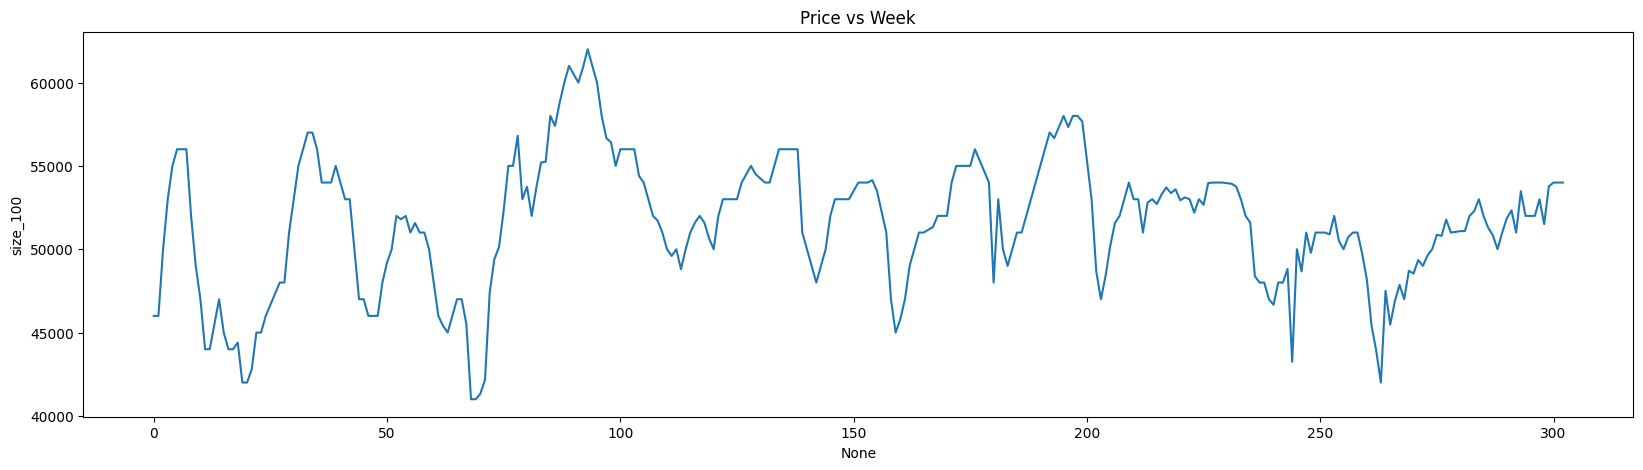

In [72]:
# Visualisasi data
fig, ax = plt.subplots(figsize=(20,5))  # Membuat area plot
sns.lineplot(x=df_valid.index, y='size_100', data=df_valid, ax=ax)  # Membuat line plot
ax.set_title('Price vs Week')  # Menambahkan judul
plt.show()

- Hasilnya tidak ada tren yang jelas dari grafik di atas. Iu mungkin dipengaruhi oleh flutuasi jangka pendek atau kejadian sporadis daripada faktor-faktor yang berkembang seiring waktu.

- Untuk itu, perlu dilakukan ekplorasi tren musiman dengan decompose data time series sebagai berikut.

## Dekomposisi

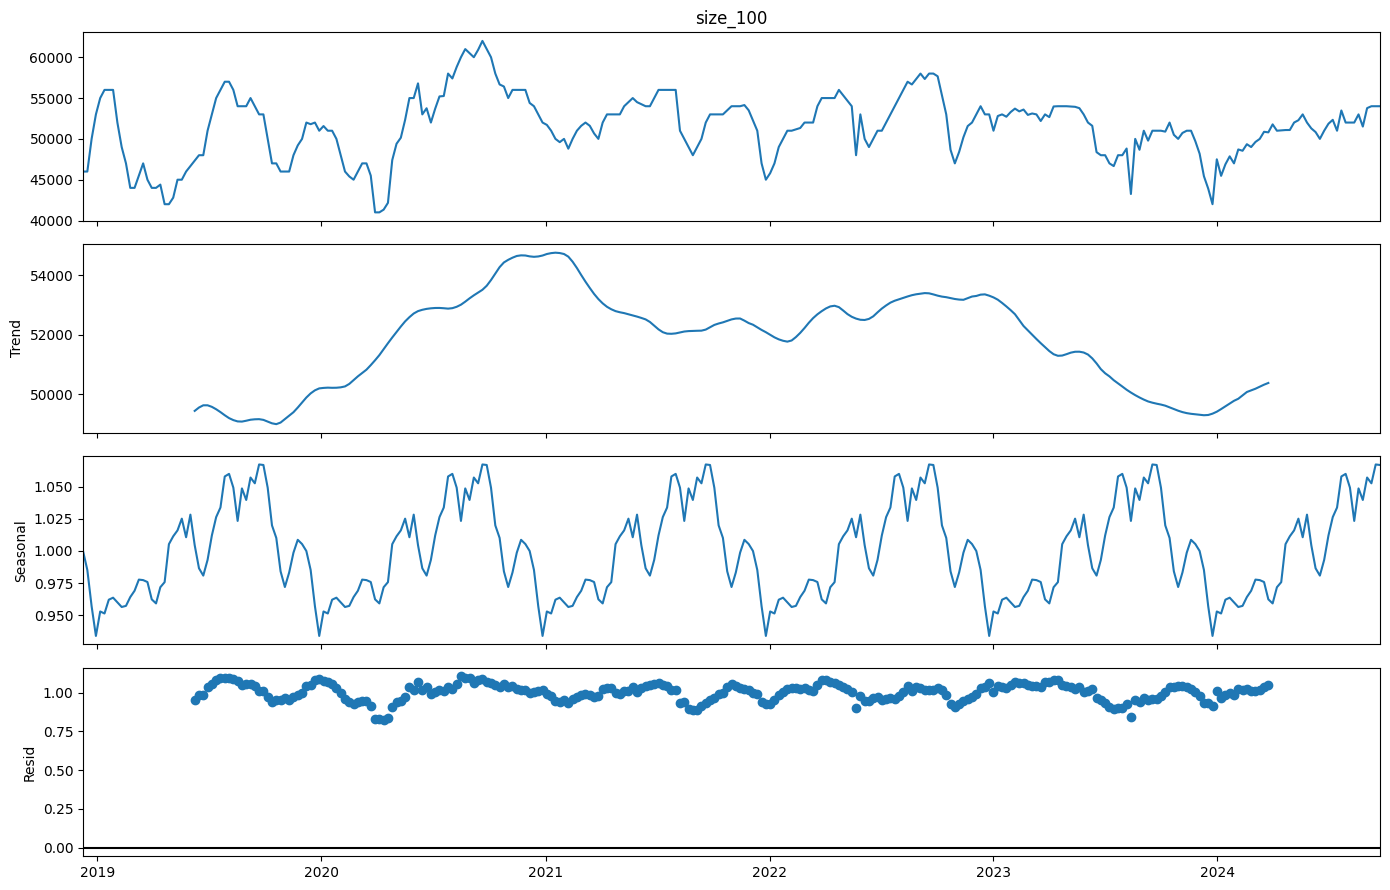

In [ ]:
# Dekomposisi timeseries

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_100['size_100'], model='multiplicatif')
ax=res.plot()
plt.show()

**Insight**

Tren:

- Tren harga udang dengan size 100 semula meningkat hingga sekitar tahun 2022. 

- Setelah itu, tren mulai menurun sampai medio 2023.

- Barulah di akhir 2023 sampai 2024, tren kembali meningkat secara perlahan

Itu menunjukkan ada perubahan signifikan dalam arah tren selama periode tersebut, yang bisa disebabkan oleh perubahan kondisi ekstrenal atau faktor musiman. <br><br>


Musiman (Seasonal):

- Tampak ada pola musiman yang cukup jelas. Dimulai dari pada quarter I harga udang ukuran 100 yang semula anjlok perlahan mulai meningkat.

- Pada quarter II , harga udang sempat mengalami penurunan, tetapi selanjutnya meningkat drastis. 

- Pada quarter III, harga udang size 100 mengalami peak season. Harga komoditas tersebut melejit.

- Harga kemudian anjlok di quarter IV dan kembali seperti saat awal quarter I. <br><br>


Residuals:

- Residuals merupakan variasi yang tidak dapat dijelaskan oleh tren atau pola musiman. Itu membantu dalam mengidentifikasi anomali atau noise dalam data yang tidak terduga.

- Dalam grafik di atas, terlihat bahwa fluktuasi residual cenderung stabil, meskipun ada sedikit penyimpangan di beberapa titik.

## Stationarity

Untuk memastikan, apakah data sudah stationary atau tidak. Data disebut stationary jika sifat statistiknya (seperti rata-rata, varians, dan kovarians) konstan sepanjang waktu. 

Namun, sebelum itu, mari kita buat fungsi untuk melakukan uji ADF

In [32]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

Fungsi sudah siap. Mari tes uji ADF untuk kolom `size_100` yang menunjukkan harga udang dengan ukuran 100.

In [33]:
# Check stationarity of the dataset

check_stationarity(df_100[['size_100']])

ADF Statistic: -4.994563
p-value: 0.000023
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Stationary


Ternyata, p-value tidak sampai 0,05 atau 5 persen. Selain itu, nilai ADF (ADF Statistics) sebesar -4.9 ternyata lebih kecil dari critical values. Oleh karena itu, data dipastikan stasionaer.

Dengan begitu, tidak perlu dilakukan differencing nantinya.

## ACF & PACF

Selanjutnya, saya akan membuat plot ACF dan PACF untuk mengetahui struktur dan hubungan dalam data time series ini. 

Itu juga bisa menunjukkan nilai p (AR order) dan q (MA order) untuk identifikasi awal orde model ARIMA

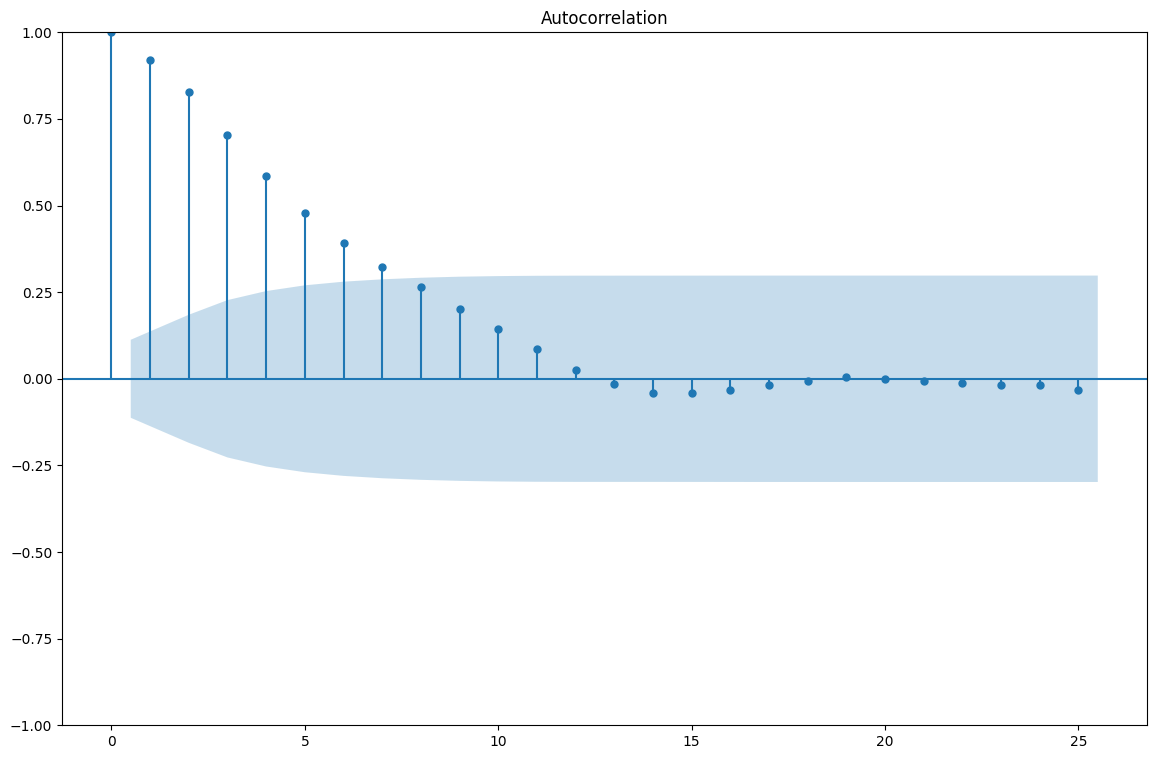

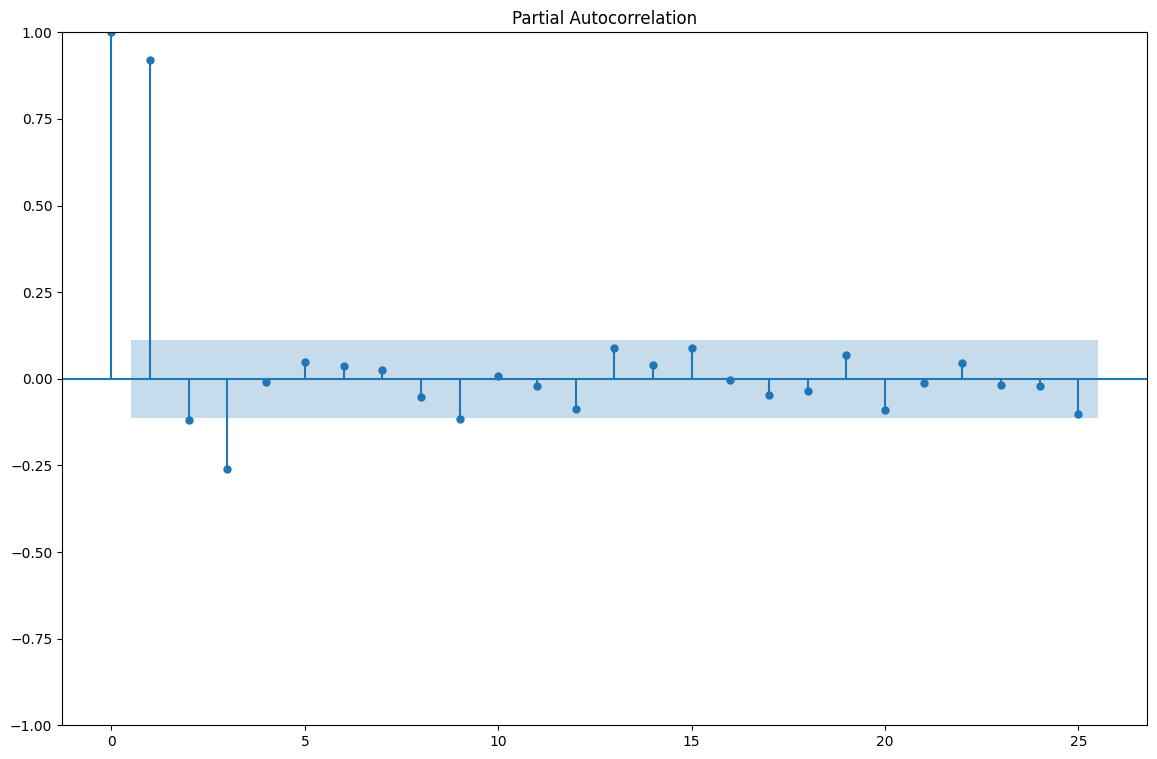

In [34]:
# plot ACF
plot_acf(df_100['size_100'])
# plot PACF
plot_pacf(df_100['size_100'])
plt.show()

**Plot ACF**

- Dari plot ACF, tidak terlihat cut off yang jelas setelah beberapa lag.

- Namun, ada penurunan bertahap yang bisa mengindikasikan komponen MA.

- Bisa dicoba q = 1 atau q = 2 sebagai awal.

**Plot PACF**

- Dilihat dari plot PACF, ada spike signifikan pada lag 1 dan 2, kemudian cut off.

- Ini menunjukkan kemungkinan p = 2.

# Modeling

Pada tahapan ini, saya akan mulai membuat model untuk data time series ini. Saya akan mencoba menggunakan ARIMA maupun SARIMA. Lalu, evaluasinya akan dibandingkan, mana yang lebih baik

## ARIMA

### Split Train dan Test

Saya akan memisahkan train dan test set sebelum melakukan model training.

In [38]:
train = df_100[:250]
test = df_100[250:]
print(f"Train Size : {train.shape}")
print(f"Test Size : {test.shape}")

Train Size : (250, 1)
Test Size : (53, 1)


Langkah ini selesai dan siap ke model training.

### Model Definition - Evaluation

Pertama-tama, saya akan membuat dahulu fungsi untuk mencari model ARIMA terbaik berdasarkan parameter p, d, dan q.

In [73]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

Fungsi sudah dibuat. Mari ke tahapan modeling selanjutnya.

In [49]:
# Mencari best model menggunakan fungsi looping
find_best_model(train.size_100,3,0,1)

(3,
 0,
 0,
 4359.885476498888,
    p  d  q          AIC
 6  3  0  0  4359.885476
 7  3  0  1  4361.869337
 4  2  0  0  4382.017096
 3  1  0  1  4385.140338
 2  1  0  0  4387.748524
 5  2  0  1  4390.784709
 1  0  0  1  4655.131900
 0  0  0  0  4875.191375)

Setelah mengetes dengan sejumlah kombinasi p, d, dan q. Kombinasi 3, 0, 1 menghasilkan nilai AIC yang paling rendah. 

Adapun parameter yang terbaik, yakni p == 3, d == 0, dan q == 0. Kombinasi parameter itulah yang saya akan pakai pada model definition berikut.

In [50]:
arima = ARIMA(train.size_100, order=(3,0,1))
mod_train_arima = arima.fit()
mod_train_arima.aic

4361.869337272604

Setelah model definition, saya akan melakukan model prediction sebagai berikut.

In [51]:

arima_pred_test_viz = mod_train_arima.predict(start="2023-09-24", end="2024-09-22",dynamic=True)

arima_pred_test_viz = pd.DataFrame(arima_pred_test_viz)

arima_pred_test_viz.columns = ['price_predict_vizplot']

In [53]:

act_vs_pred_sar = pd.concat([test, arima_pred_test_viz], axis=1)
print(act_vs_pred_sar)

                size_100  price_predict_vizplot
2023-09-24  51000.000000           50914.462470
2023-10-01  51000.000000           51356.112369
2023-10-08  50888.888889           51452.788794
2023-10-15  52000.000000           51636.416795
2023-10-22  50500.000000           51711.927236
2023-10-29  50000.000000           51786.263466
2023-11-05  50727.272727           51819.850801
2023-11-12  51000.000000           51842.222346
2023-11-19  51000.000000           51847.923447
2023-11-26  49714.285714           51846.666260
2023-12-03  48181.818182           51839.284635
2023-12-10  45428.571429           51829.509350
2023-12-17  43909.090909           51818.512853
2023-12-24  42000.000000           51807.758554
2023-12-31  47500.000000           51797.834133
2024-01-07  45473.684211           51789.195857
2024-01-14  46882.352941           51781.963883
2024-01-21  47862.068966           51776.146042
2024-01-28  47000.000000           51771.628099
2024-02-04  48705.882353           51768

In [57]:
# memprediksi feature values
arima_pred_test_find = mod_train_arima.predict(start="2023-09-24", end="2024-09-22")
# mengonversi Prediksi ke dalam DataFrame
arima_pred_test_find = pd.DataFrame(arima_pred_test_find)
# ganti nama kolom
arima_pred_test_find.columns = ['price_predict_findfunc']
# Concate dengan actual test set
act_vs_pred_sar['price_predict_findfunc'] = arima_pred_test_find['price_predict_findfunc']
act_vs_pred_sar

,size_100,price_predict_vizplot,price_predict_findfunc
2023-09-24,51000.000000,50914.462470,50914.462470
2023-10-01,51000.000000,51356.112369,51356.112369
2023-10-08,50888.888889,51452.788794,51452.788794
2023-10-15,52000.000000,51636.416795,51636.416795
2023-10-22,50500.000000,51711.927236,51711.927236
2023-10-29,50000.000000,51786.263466,51786.263466
2023-11-05,50727.272727,51819.850801,51819.850801
2023-11-12,51000.000000,51842.222346,51842.222346
2023-11-19,51000.000000,51847.923447,51847.923447
2023-11-26,49714.285714,51846.666260,51846.666260


- Lalu saya akan melihat dengan evaluasi model dengan metrik MAE.

- Penggunaan metrik ini untuk memperlihatkan nilai riil rata-rata eror dari selisih prediksi dan aktual pada test set.

In [58]:
print('MAE test  : ', mean_absolute_error(test, arima_pred_test_find))
print('RMSE test : ', np.sqrt(mean_squared_error(test, arima_pred_test_find)))

MAE test  :  1915.965715058392
RMSE test :  2821.546675190673


Tampak rerata selisih antara prediksi dan harga aktual sekitar Rp 1.915. Eror tersebut dirasa cukup normal untuk kisaran harga komoditas yang bisa mencapai Rp 50 ribuan.

Namun, untuk melihat persentasi margin error-nya mari gunakan juga metrik MAPE. Adapun berikut tahapan untuk mencari MAPE-nya.

In [59]:
# Melakukan prediksi 
 
size = int(len(train.size_100) - 30)
train.size_100, test = train.size_100[0:size], train.size_100[size:len(train.size_100)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train.size_100]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(3,0,1))
    model_arima_100 = model.fit()
    
    output = model_arima_100.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 51879.964457, expected = 52937.500000
predicted = 52869.191567, expected = 53111.111111
predicted = 53060.636541, expected = 53000.000000
predicted = 52897.597224, expected = 52191.489362
predicted = 51933.253375, expected = 53000.000000
predicted = 52890.558545, expected = 52666.666667
predicted = 52684.026897, expected = 53971.428571
predicted = 54004.309052, expected = 54000.000000
predicted = 54097.026867, expected = 54000.000000
predicted = 53803.048196, expected = 54000.000000
predicted = 53782.572633, expected = 53964.285714
predicted = 53741.840041, expected = 53928.571429
predicted = 53702.411147, expected = 53761.904762
predicted = 53521.486841, expected = 53000.000000
predicted = 52661.549678, expected = 52000.000000
predicted = 51562.663404, expected = 51600.000000
predicted = 51289.191725, expected = 48375.000000
predicted = 47841.342911, expected = 48000.000000
predicted = 47526.862035, expected = 48000.000000
predicted

In [60]:
# Menghitung MAPE
mape = np.mean(np.abs((test - predictions) / test)) * 100

print('MAPE test : ', mape)

MAPE test :  2.0802359883372263


Ternyata margin eror dari model ini hanya 2 persenan saja.

# SARIMA 100

### Split Train dan Test

Saya akan memisahkan train dan test set sebelum melakukan model training.

In [63]:
train_size = int(0.8 * len(df_valid.size_100))
train_sar = df_valid[:train_size]
test_sar = df_valid[train_size:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (250, 1)
Test size :  (30,)


In [64]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

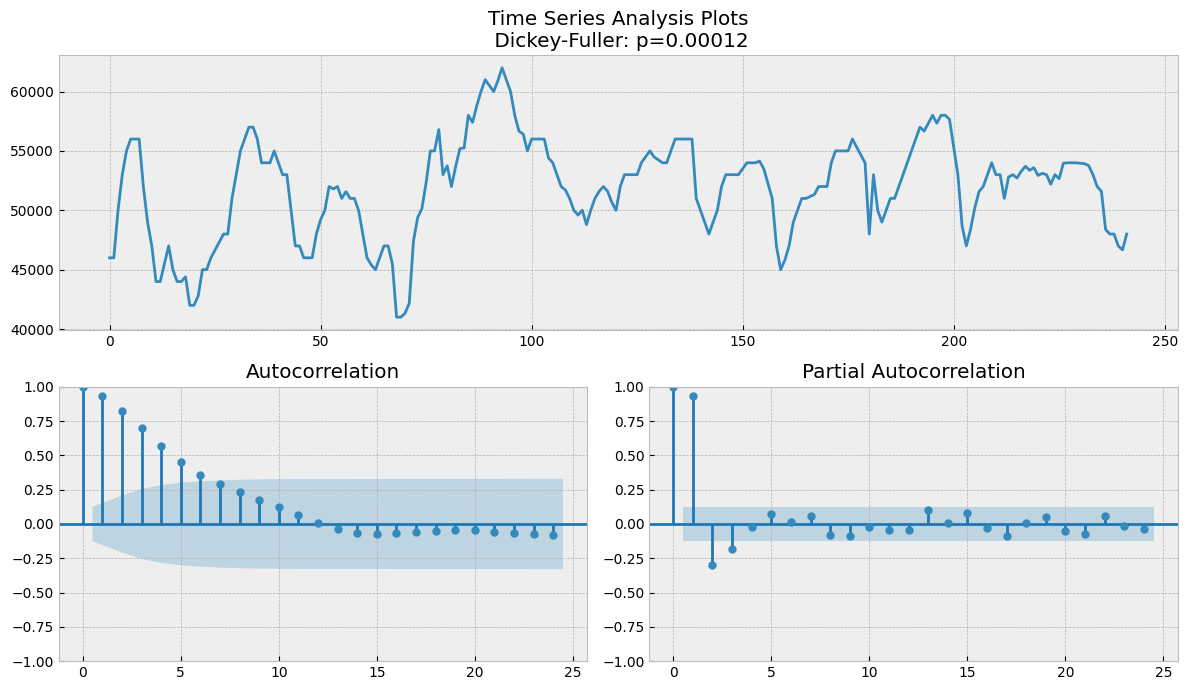

In [65]:
tsplot(train_sar.size_100)

In [81]:
# If train_sar is a DataFrame with one column
if isinstance(train_sar, pd.DataFrame):
    train_sar = train_sar.iloc[:, 0]  # Get the first column as a Series

In [84]:
train_sar = pd.to_numeric(train_sar, errors='coerce')

In [85]:
# Train using SARIMAX

model_sarima_100=SARIMAX(train_sar, order=(3, 0, 1),seasonal_order=(0, 0, 5, 27)).fit()
model_sarima_100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                                             date   No. Observations:                  242
Model:             SARIMAX(3, 0, 1)x(0, 0, [1, 2, 3, 4, 5], 27)   Log Likelihood                   0.000
Date:                                          Thu, 26 Sep 2024   AIC                             20.000
Time:                                                  12:40:47   BIC                             54.889
Sample:                                                       0   HQIC                            34.055
                                                          - 242                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0         -0        nan        nan           0          -0
ar.L2               0         -0        nan        nan           0           0
ar.L3               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ma.S.L27            0         -0        nan        nan           0           0
ma.S.L54            0         -0        nan        nan           0           0
ma.S.L81            0         -0        nan        nan           0           0
ma.S.L108           0         -0        nan        nan           0           0
ma.S.L135           0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict test-set
sar_pred_test = model_sarima_100.predict(start="2023-07-30", end="2024-09-22", dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)

# Reset index for alignment
test_sar_reset = test_sar.reset_index(drop=True)
sar_pred_test_reset = sar_pred_test.reset_index(drop=True)

# Concatenate predictions with actual values
act_vs_pred_sar = pd.concat([test_sar_reset, sar_pred_test_reset], axis=1)

# Check the MAE & RMSE
mae_test = mean_absolute_error(test_sar_reset, sar_pred_test_reset)
rmse_test = np.sqrt(mean_squared_error(test_sar_reset, sar_pred_test_reset))

print('MAE test  : ', mae_test)
print('RMSE test : ', rmse_test)

# Display actual vs predicted
print(act_vs_pred_sar)

In [221]:
# Menghitung MAPE dengan menangani pembagian dengan nol
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Mengabaikan nilai aktual yang sama dengan nol untuk menghindari pembagian dengan nol
    non_zero_idx = y_true != 0
    y_true_non_zero = y_true[non_zero_idx]
    y_pred_non_zero = y_pred[non_zero_idx]
    
    # Hitung MAPE hanya pada data yang tidak memiliki nilai aktual nol
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

# Contoh penggunaan
mape_test = mean_absolute_percentage_error(test_sar_reset, sar_pred_test_reset)
print('MAPE test: ', mape_test)

MAPE test:  6.15346726457562


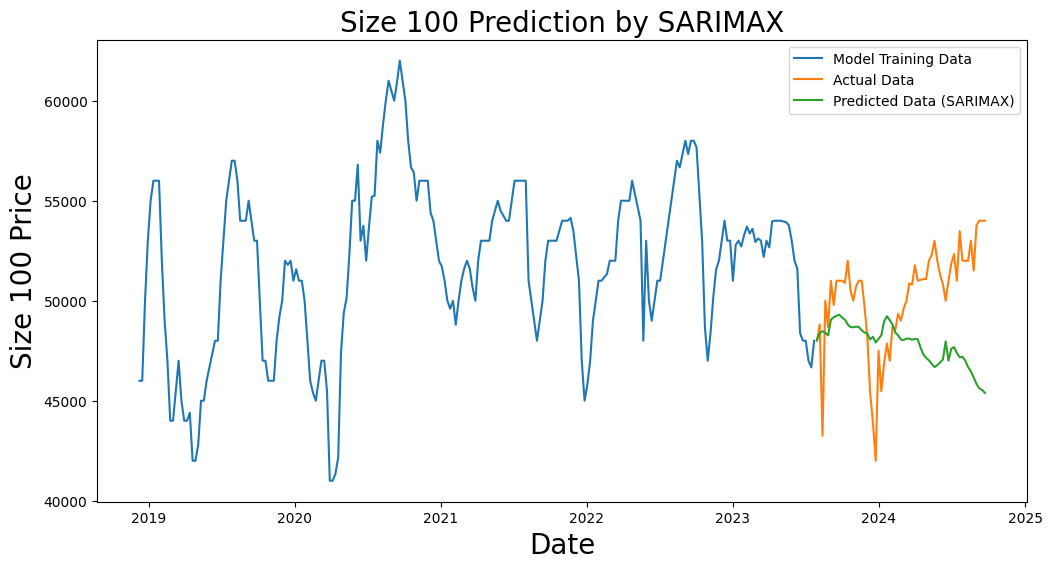

In [222]:
# Plotting the SARIMAX model results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_sar, label='Model Training Data')

# Plot actual test data
plt.plot(test_sar.index, test_sar, label='Actual Data')

# Plot predicted test data
plt.plot(test_sar.index, sar_pred_test_reset, label='Predicted Data (SARIMAX)')

# Adding labels, title, and legend
plt.xlabel('Date', size=20)
plt.ylabel('Size 100 Price', size=20)
plt.title('Size 100 Prediction by SARIMAX', size=20)
plt.legend()

# Show plot
plt.show()

# Conclusion

Dari hasil evaluasi yang telah dilakukan, model ARIMA dengan PDQ dari Plot Visual lebih menunjukkan prediksi yang lebih akurat daripada PDQ yang didapat dari find best model maupun model SARIMA.

Hal ini bisa dilihat dari indikator MAE dan MAPE yang jelas perbedaannya. MAE dan MAPE ARIMA lebih rendah daripada SARIMA sehingga model yang akan dipakai untuk memprediksi data harga udang size 100.

# Model Saving

In [76]:
with open('model100.pkl', 'wb') as model100_file:
    pickle.dump(mod_train_arima, model100_file)